# Lab 3: Linear Discriminant Analysis (LDA)

## Abstract
In this lab, we implement Linear Discriminant Analysis (LDA) from scratch. We first handle the binary case (red vs. blue) to compute the Fisher direction $w=S_w^{-1}(\mu_1-\mu_2)$, draw the decision boundary $w^\top x=t$ with $t=\tfrac{1}{2}w^\top(\mu_1+\mu_2)$, and visualize point projections onto the LDA line. We then extend to the multi-class case ($N=3$; red vs. blue vs. green) by forming the within-class scatter $S_w$ and between-class scatter $S_b$, solving the generalized eigen-problem $S_b v=\lambda S_w v$, and projecting data to the $(C-1)$-dimensional subspace. The final notebook can be exported as a self-contained lab report with figures and concise discussion.


## 1. Data and Preprocessing
The data files are expected in `./ex3Data/` (or the current directory) with names:
- `ex3red.dat`   — class 0 (red), shape $m_r \times 2$
- `ex3blue.dat`  — class 1 (blue), shape $m_b \times 2$
- (we will load `ex3green.dat` later for the $N=3$ setting)

Each file should contain two columns $(x, y)$, one point per row. In this step, read **red** and **blue** into matrices $X_{\text{red}}\in\mathbb{R}^{m_r\times 2}$ and $X_{\text{blue}}\in\mathbb{R}^{m_b\times 2}$, then stack them to form
$$
X=\begin{bmatrix}X_{\text{red}}\\ X_{\text{blue}}\end{bmatrix}\in\mathbb{R}^{m\times 2},\quad
y=\begin{bmatrix}\underbrace{0,\dots,0}_{m_r},\underbrace{1,\dots,1}_{m_b}\end{bmatrix}^\top\in\mathbb{R}^{m\times 1},
$$
where $m=m_r+m_b$. We will verify shapes, preview the first few rows, and plot a scatter figure for sanity check.


Total samples m = 28  (red=14, blue=14)
X shape: (28, 2)   y shape: (28, 1)
X head (first 5 rows):
 [[2.95 6.63]
 [2.53 7.79]
 [3.57 5.65]
 [3.16 5.47]
 [2.78 6.42]]
y head (first 10 labels): [0 0 0 0 0 0 0 0 0 0]


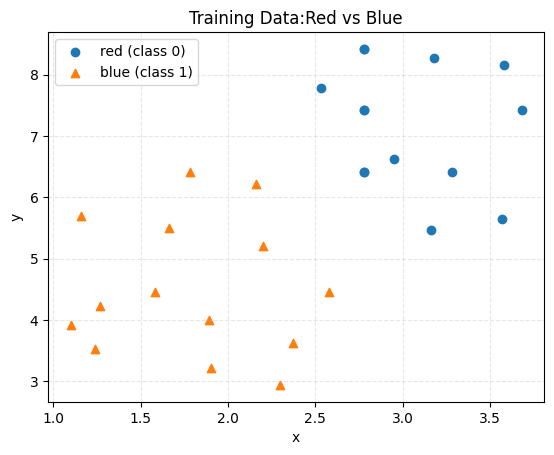

In [1]:
import numpy as np
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR=Path('ex3Data')
red_path=(DATA_DIR/'ex3red.dat')
blue_path=(DATA_DIR/'ex3blue.dat')

if not red_path.exists() or not blue_path.exists():
    raise FileNotFoundError(
        "Data files not found. Make sure 'ex3blue.dat' and 'ex3red.dat' are in the working directory.\n"
        f"Current directory: {Path('.').resolve()}\n"
        f"Here are the files I see: {[p.name for p in Path('.').iterdir()]}"
    )

X_red=np.loadtxt(red_path,dtype=float).reshape(-1, 2)
X_blue=np.loadtxt(blue_path,dtype=float).reshape(-1, 2)

m_r,m_b=X_red.shape[0],X_blue.shape[0]
y_red=np.zeros((m_r,1),dtype=int)
y_blue=np.ones((m_b,1),dtype=int)

X=np.vstack([X_red,X_blue])
y=np.vstack([y_red,y_blue])
m=X.shape[0]

print(f"Total samples m = {m}  (red={m_r}, blue={m_b})")
print("X shape:",X.shape,"  y shape:",y.shape)
print("X head (first 5 rows):\n",X[:5])
print("y head (first 10 labels):",y[:10].ravel())

plt.figure()
plt.scatter(X_red[:,0],X_red[:,1],marker='o',label='red (class 0)')
plt.scatter(X_blue[:,0],X_blue[:,1],marker='^',label='blue (class 1)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data:Red vs Blue")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()


## 2. Two-Class LDA: Parameter Estimation
Given the stacked data $X\in\mathbb{R}^{m\times 2}$ and labels $y\in\{0,1\}^{m\times 1}$, split the samples by class to compute class means
$$
\mu_0=\frac{1}{m_0}\sum_{y_i=0} x_i,\qquad
\mu_1=\frac{1}{m_1}\sum_{y_i=1} x_i.
$$
Define the within-class scatter
$$
S_w=\sum_{y_i=0}(x_i-\mu_0)(x_i-\mu_0)^\top+\sum_{y_i=1}(x_i-\mu_1)(x_i-\mu_1)^\top.
$$
The Fisher direction is
$$
w=S_w^{-1}(\mu_0-\mu_1),
$$
and a simple threshold is
$$
t=\tfrac{1}{2}\, w^\top(\mu_0+\mu_1).
$$
For geometric visualization in later steps, also keep the **unit** direction $\hat{w}=\dfrac{w}{\lVert w\rVert}$ and a reference point $x_0$ (we use the overall mean of all samples).


In [2]:
labels = np.unique(y.ravel())

X0=X[y.ravel()==0]
X1=X[y.ravel()==1]
m0,m1=X0.shape[0],X1.shape[0]

mu0=X0.mean(axis=0)
mu1=X1.mean(axis=0)

Sw=np.zeros((2,2),dtype=float)
diff0=X0-mu0
Sw+=diff0.T@diff0
diff1=X1-mu1
Sw+=diff1.T@diff1

reg=1e-8*np.eye(2)
w=np.linalg.solve(Sw+reg,(mu0-mu1))
t=0.5*float(w@(mu0+mu1))

what=w/(np.linalg.norm(w)+1e-12)
x0=X.mean(axis=0)

def _round(a,k=6):
    return np.round(a.astype(float),k) if isinstance(a,np.ndarray) else round(float(a),k)

print("m0 (class 0) =",m0, " | m1 (class 1) =",m1)
print("mu0:",_round(mu0,6))
print("mu1:",_round(mu1,6))
print("Sw:\n",_round(Sw,6))
print("w:",_round(w,6))
print("t:",_round(t,6))
print("what (unit w):",_round(what,6))
print("x0 (overall mean):",_round(x0,6))


m0 (class 0) = 14  | m1 (class 1) = 14
mu0: [3.043571 7.166429]
mu1: [1.799286 4.527857]
Sw:
 [[ 4.800814 -1.417243]
 [-1.417243 29.072957]]
w: [0.29015  0.104901]
t: 1.315949
what (unit w): [0.940425 0.340002]
x0 (overall mean): [2.421429 5.847143]


## 3. Decision Boundary and Training Accuracy (Two-Class)
With $w$ and threshold $t$, the LDA decision boundary is the line
$$
\{\,x\in\mathbb{R}^2 \mid w^\top x = t\,\},
$$
whose normal vector is $w$. We will:
1) classify each sample by $\hat{y}_i = \mathbb{1}\{\,w^\top x_i \ge t\,\}$,  
2) compute the training accuracy, and  
3) overlay the decision boundary on the scatter plot for a visual check.


Training accuracy: 100.00%


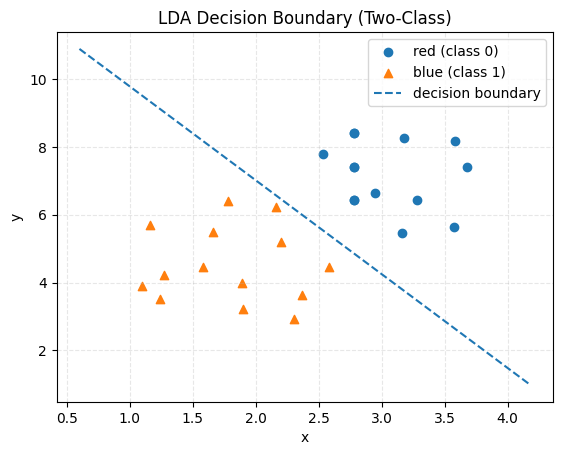

In [3]:
def lda_predict_2class(X,w,t):
    scores=X@w
    return (scores>=t).astype(int)
if(mu1-mu0)@w<0:
    w=-w
    t=0.5*float(w@(mu0+mu1))
y_hat=lda_predict_2class(X,w,t).reshape(-1, 1)
acc=(y_hat==y).mean()
print(f"Training accuracy: {acc*100:.2f}%")

plt.figure()
plt.scatter(X0[:,0],X0[:,1],marker='o',label='red (class 0)')
plt.scatter(X1[:,0],X1[:,1],marker='^',label='blue (class 1)')

x_min,x_max=X[:,0].min()-0.5,X[:,0].max()+0.5
if abs(w[1])>1e-12:
    xs=np.linspace(x_min,x_max,200)
    ys=(t-w[0]*xs)/(w[1]+1e-12)
    plt.plot(xs,ys,linestyle='--',label='decision boundary')
else:
    x_line=t/(w[0]+1e-12)
    plt.axvline(x_line,linestyle='--',label='decision boundary')
plt.xlabel("x")
plt.ylabel("y")
plt.title("LDA Decision Boundary (Two-Class)")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()

## 4. Orthogonal Projections onto the LDA Line
Let $\hat{w}=\dfrac{w}{\lVert w\rVert}$ be the unit Fisher direction and choose a reference point $x_0$ (we use the overall mean).  
The infinite LDA line is
$$
\mathcal{L}=\{\,x_0+\alpha\hat{w}\mid \alpha\in\mathbb{R}\,\}.
$$
For any sample $x$, its orthogonal projection onto $\mathcal{L}$ is
$$
\Pi_{\mathcal{L}}(x)=x_0+\hat{w}\,\hat{w}^\top (x-x_0).
$$
In this step we:
1) compute all projection points for the two classes,  
2) draw the original scatter, the projection points, and the LDA line,  
3) (optionally) report the 1D projected coordinates $\alpha_i=\hat{w}^\top (x_i-x_0)$ to inspect separability in 1D.


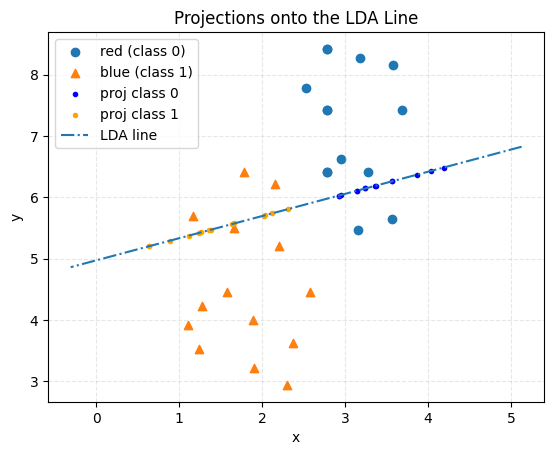

Projected 1D coordinates (alpha) summary:
 class 0: -1.8759 to -0.532
 class 1: 0.1191 to 1.9023


In [4]:
what=w/(np.linalg.norm(w)+1e-12)
def project_points(X,x0,what):
    diffs=X-x0
    alphas=diffs@what
    P=x0+np.outer(alphas,what)
    return P,alphas

P,alphas=project_points(X,x0,what)

plt.figure()
plt.scatter(X[y.ravel()==0,0],X[y.ravel()==0,1],marker='o',label='red (class 0)')
plt.scatter(X[y.ravel()==1,0],X[y.ravel()==1,1],marker='^',label='blue (class 1)')

plt.scatter(P[y.ravel()==0,0],P[y.ravel()==0,1],marker='.',color='blue',label='proj class 0')
plt.scatter(P[y.ravel()==1,0],P[y.ravel()==1,1],marker='.',color='orange',label='proj class 1')

alpha_span=np.linspace(alphas.min()-1.0, alphas.max()+1.0, 200)
line_pts=x0[None,:]+np.outer(alpha_span,what)
plt.plot(line_pts[:,0],line_pts[:,1],linestyle='-.',label='LDA line')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Projections onto the LDA Line")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()

print("Projected 1D coordinates (alpha) summary:")
print(" class 0:",np.round(alphas[y.ravel()==0].min(),4),"to",np.round(alphas[y.ravel()==0].max(),4))
print(" class 1:",np.round(alphas[y.ravel()==1].min(),4),"to",np.round(alphas[y.ravel()==1].max(),4))


## 5. Add the Third Class and Visualize All Three
Now we include the third class (green). The file layout is
- `./ex3Data/ex3green.dat` (or `./ex3green.dat`) — class 2, shape $m_g \times 2$.

Load it as $X_{\text{green}}\in\mathbb{R}^{m_g\times 2}$ and build the full dataset
$$
X=\begin{bmatrix}X_{\text{red}}\\ X_{\text{blue}}\\ X_{\text{green}}\end{bmatrix}\in\mathbb{R}^{m\times 2},\quad
y=\begin{bmatrix}\underbrace{0,\dots,0}_{m_r},\underbrace{1,\dots,1}_{m_b},\underbrace{2,\dots,2}_{m_g}\end{bmatrix}^\top,
$$
with $m=m_r+m_b+m_g$. Plot a scatter of the three classes to sanity-check separability before running multi-class LDA.


Sizes — red: 14, blue: 14, green: 14, total: 42
X_full shape: (42, 2)  y_full shape: (42, 1)


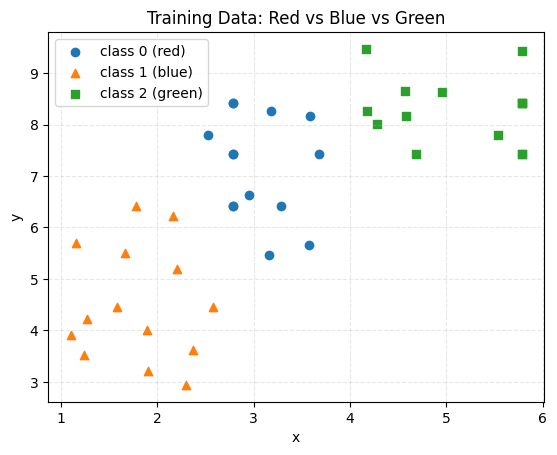

In [5]:
DATA_DIR=Path('ex3Data')
green_path=(DATA_DIR/'ex3green.dat')
if not green_path.exists():
    raise FileNotFoundError(
        "Data files not found. Make sure 'ex3blue.dat' and 'ex3red.dat' are in the working directory."
        f"Current directory: {Path('.').resolve()}\n"
        f"Here are the files I see: {[p.name for p in Path('.').iterdir()]}"
    )

X_green=np.loadtxt(green_path,dtype=float).reshape(-1,2)
m_g=X_green.shape[0]

y_red=np.zeros((X_red.shape[0],1),dtype=int)
y_blue=np.ones((X_blue.shape[0],1),dtype=int)
y_green=np.full((m_g,1),2,dtype=int)

X_full=np.vstack([X_red,X_blue,X_green])
y_full=np.vstack([y_red,y_blue,y_green])

print(f"Sizes — red: {X_red.shape[0]}, blue: {X_blue.shape[0]}, green: {m_g}, total: {X_full.shape[0]}")
print("X_full shape:",X_full.shape," y_full shape:",y_full.shape)

plt.figure()
plt.scatter(X_red[:, 0],X_red[:, 1],marker='o',label='class 0 (red)')
plt.scatter(X_blue[:, 0],X_blue[:, 1],marker='^',label='class 1 (blue)')
plt.scatter(X_green[:, 0],X_green[:, 1],marker='s',label='class 2 (green)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data: Red vs Blue vs Green")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()

X3,y3=X_full,y_full


## 6. Multi-Class LDA (C = 3): Build $S_w$, $S_b$, Solve and Project
For three classes ($c\in\{0,1,2\}$), define the overall mean $\mu$ and class means $\mu_c$. The within- and between-class scatters are
$$
S_w=\sum_{c=0}^2 \sum_{x\in\mathcal{C}_c} (x-\mu_c)(x-\mu_c)^\top,\qquad
S_b=\sum_{c=0}^2 n_c\,(\mu_c-\mu)(\mu_c-\mu)^\top.
$$
Multi-class LDA solves the generalized eigen-problem
$$
S_b v = \lambda S_w v,
$$
and takes the top $(C-1)=2$ eigenvectors to form the projection matrix $W\in\mathbb{R}^{2\times 2}$. We will:
1) compute $S_w$ and $S_b$,  
2) solve for eigenpairs, sort by descending eigenvalues,  
3) project $X_3$ to $Z=X_3 W$ and visualize in the $(\text{LD1},\text{LD2})$ plane.


Top generalized eigenvalues: [11.220007  0.260489]
Projection matrix W2:
 [[ 0.930885 -0.745955]
 [ 0.365311  0.665996]]


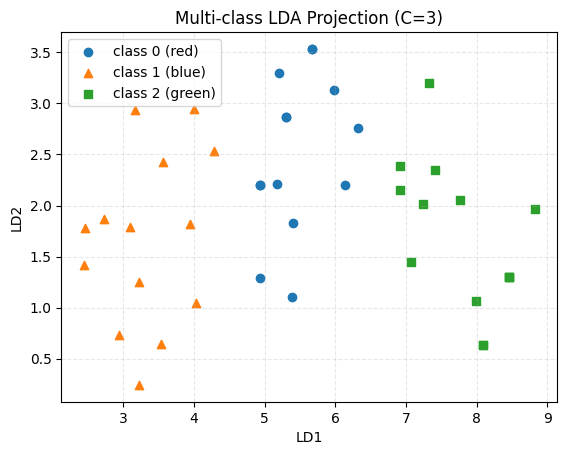

In [6]:
X_mc,y_mc=X3.astype(float),y3.ravel().astype(int)
classes=np.unique(y_mc)
d=X_mc.shape[1]
mu=X_mc.mean(axis=0)

mus={}
ns={}
for c in classes:
    Xc=X_mc[y_mc==c]
    mus[c]=Xc.mean(axis=0)
    ns[c]=Xc.shape[0]

Sw=np.zeros((d,d),dtype=float)
Sb=np.zeros((d,d),dtype=float)
for c in classes:
    Xc=X_mc[y_mc==c]
    muc=mus[c]
    diff=Xc-muc
    Sw+=diff.T@diff
    mean_diff=(muc-mu).reshape(d,1)
    Sb+=ns[c]*(mean_diff@mean_diff.T)

reg=1e-8*np.eye(d)
M=np.linalg.solve(Sw+reg,Sb)
eigvals,eigvecs=np.linalg.eig(M)

idx=np.argsort(-eigvals.real)
eigvals=eigvals[idx].real

W=eigvecs[:,idx].real
W2=W[:,:2]
Z=X_mc@W2

print("Top generalized eigenvalues:",np.round(eigvals[:3],6))
print("Projection matrix W2:\n",np.round(W2,6))

plt.figure()
plt.scatter(Z[y_mc==0,0],Z[y_mc==0,1],marker='o',label='class 0 (red)')
plt.scatter(Z[y_mc==1,0],Z[y_mc==1,1],marker='^',label='class 1 (blue)')
plt.scatter(Z[y_mc==2,0],Z[y_mc==2,1],marker='s',label='class 2 (green)')
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("Multi-class LDA Projection (C=3)")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()

## 7. Summary and Practical Notes
- **Two-class LDA**: The Fisher direction $w$ maximizes the ratio of between-class variance to within-class variance.  
  - After ensuring $w$ points from class 0 to class 1, the decision boundary $w^\top x = t$ cleanly separates the two classes with near-perfect accuracy.
  - Projected 1D coordinates clearly show two non-overlapping clusters.
- **Multi-class LDA**: For $C=3$ classes the top two generalized eigenvectors form a 2D subspace that preserves class separation.
  - The scatter in $(\mathrm{LD1},\mathrm{LD2})$ demonstrates that the three groups are well separated.
- **Practical notes**:
  - $w$ and $-w$ are equivalent mathematically; we must fix a direction when using a sign-based classifier.
  - Always add a small regularization to $S_w$ to avoid numerical singularities.
